<a href="https://colab.research.google.com/github/TatianaKazanceva/Prosti-hospodi/blob/main/Finalny_proekt_infa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ПРЕДОБРАБОТКА: ТОКИНЕНИЗАЦИЯ, ЛЕММАТИЗАЦИЯ

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import numpy as np
import pandas as pd
import re
import nltk
#import spacy
import string

In [11]:
##Чтение датасета с текстом
df = pd.read_csv("/content/poems.csv", encoding='utf-8', sep=",")
df.head()

,writer,poem,text
0,Лермонтов Михаил Юрьевич,Любовь мертвеца,NaN
1,Лермонтов Михаил Юрьевич,На серебряные шпоры…,На серебряные шпоры\nЯ в раздумии гляжу;\nЗа т...
2,Лермонтов Михаил Юрьевич,Вид гор из степей Козлова,Пилигрим\nАллах ли там среди пустыни\nЗастывши...
3,Лермонтов Михаил Юрьевич,"К (О, не скрывай! Ты плакала об нем…)","О, не скрывай! Ты плакала об нем –\nИ я его лю..."
4,Лермонтов Михаил Юрьевич,"Жалобы турка (письмо к другу, иностранцу)","Ты знал ли дикий край, под знойными лучами,\nГ..."


In [12]:
#help(pd.read_csv)
!pip install Pymorphy2

In [13]:
df.head(5)

,writer,poem,text
0,Лермонтов Михаил Юрьевич,Любовь мертвеца,NaN
1,Лермонтов Михаил Юрьевич,На серебряные шпоры…,На серебряные шпоры\nЯ в раздумии гляжу;\nЗа т...
2,Лермонтов Михаил Юрьевич,Вид гор из степей Козлова,Пилигрим\nАллах ли там среди пустыни\nЗастывши...
3,Лермонтов Михаил Юрьевич,"К (О, не скрывай! Ты плакала об нем…)","О, не скрывай! Ты плакала об нем –\nИ я его лю..."
4,Лермонтов Михаил Юрьевич,"Жалобы турка (письмо к другу, иностранцу)","Ты знал ли дикий край, под знойными лучами,\nГ..."


In [14]:
from nltk.corpus import stopwords
with open("stopwords.txt", 'r', encoding="utf8") as f:
    STOPWORDS = f.read().splitlines()
# функция, удаляющая стопслова из текстов
def stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
# Удаление эмодзи
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
#Удаление URL
# Function for url's
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
from bs4 import BeautifulSoup
#Function for removing html
def html(text):
    return BeautifulSoup(text, "lxml").text
#Можно выполнить при помощи NLTK. Заодно проведем лемматизацию
from pymorphy2 import MorphAnalyzer
from nltk import sent_tokenize, word_tokenize, regexp_tokenize

def tokenize_lemmas(sent, pat=r"(?u)\b\w\w+\b", morph=MorphAnalyzer()):
    return [morph.parse(tok)[0].normal_form
            for tok in regexp_tokenize(sent, pat)]

In [15]:
df['text_ready']  = df['text'].str.lower()
df['text_ready'] = df['text_ready'].str.replace('\d+', '')
df['text_ready'] = df['text_ready'].str.replace('[^\w\s]','')
df["text_ready"] = df["text_ready"].apply(stopwords)
df['text_ready'] = df['text_ready'].apply(emoji)
df['text_ready'] = df['text_ready'].apply(remove_urls)
df['text_ready'] = df['text_ready'].apply(html) #удаляет теги
df["text_ready"] = df["text_ready"].map(lambda x: " ".join(tokenize_lemmas(x)))
df[['text_ready']].head()

,text_ready
0,nan
1,серебряный шпор раздумия глядеть ты скакун ско...
2,пилигрим аллах среди пустынь застывший волна в...
3,скрывать плакать любить заслужить твой слеза в...
4,знать дикий край знойный луч роща луг поблёкну...


In [16]:
# WORD EMBEDDING: ОБУЧАЕМ МОДЕЛЬ

In [17]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [18]:
#help(Word2Vec)

In [19]:
w2v_model = Word2Vec(
    min_count=10,
    window=2,
    vector_size=3000,
    negative=5,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)
#min_count — минимальное число вхождений слова
#window — расстояние между current и predicted слов
#vector_size — размер векторного представления слова (word embedding) — размер матрицы
#negative — сколько неконтекстных слов учитывать в обучении, используя negative sampling — число слов
#alpha — начальный learning_rate, используемый в алгоритме обратного распространения ошибки (Backpropogation).Задаем угол наклон распределения
#min_alpha — минимальное значение learning_rate, на которое может опуститься в процессе обучения.
#sg — если 1, то используется реализация Skip-gram; если 0, то CBOW.

In [20]:
#Получаем лист слов
from nltk.tokenize import sent_tokenize
from gensim.utils import simple_preprocess

class MySentences(object):
    def __init__(self, docs):
        self.corpus = docs
    def __iter__(self):
        for doc in self.corpus:
            doc_sentences = sent_tokenize(doc)
            for sent in doc_sentences:
                yield simple_preprocess(sent) # yields a tokenized

In [21]:
sentences = MySentences(df['text_ready'].tolist())

In [22]:
#Получаем словарь
w2v_model.build_vocab(sentences)

In [23]:
#Обучение
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=6, report_delay=1)

(9077792, 14053380)

In [24]:
#для сохранения оперативной памяти можно написать следующее
w2v_model.init_sims(replace=True)

<ipython-input-24-ccdb4c4f0af4>:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [59]:
# TF-IDF (КЛЮЧЕВЫЕ СЛОВА)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True) #rk.xtdst ckjdf

In [27]:
texts = df.text_ready
texts

0                                                      nan
1        серебряный шпор раздумия глядеть ты скакун ско...
2        пилигрим аллах среди пустынь застывший волна в...
3        скрывать плакать любить заслужить твой слеза в...
4        знать дикий край знойный луч роща луг поблёкну...
                               ...                        
19311    хорошо мир магический ночь мерный скрип высоки...
19312    пробочка крепкий иод скоро перетлеть незримо ж...
19313    друг друг мочь скоро сон ява нить пустой разго...
19314    увы дитя душа неутолённый сниться ль невыразим...
19315    изломать одолевать нестерпимый скука утро чей ...
Name: text_ready, Length: 19316, dtype: object

In [28]:
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(texts)

In [29]:
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]

In [58]:
df1 = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names_out(), columns=["tfidf"])
df1.sort_values(by=["tfidf"],ascending=False)[:20]

,tfidf
nan,1.0
000,0.0
почтовый,0.0
почувствоваль,0.0
почувствовалъ,0.0
почувствовавъ,0.0
почтѣніь,0.0
почтѣніть,0.0
почтѣние,0.0
почтѣ,0.0


In [66]:
# СИНОНИМИЧЕСКАЯ БЛИЗОСТЬ

In [31]:
w2v_model.wv.most_similar(positive=["чувство"], topn=10)

[('нежность', 0.9522289633750916),
 ('воображение', 0.9515024423599243),
 ('идеал', 0.9424160122871399),
 ('впечатление', 0.9389333724975586),
 ('избыток', 0.9380809664726257),
 ('выразить', 0.9345113635063171),
 ('вымысел', 0.9319538474082947),
 ('предаваться', 0.9268723726272583),
 ('полнота', 0.9215254187583923),
 ('стыдливость', 0.920731782913208)]

In [32]:
w2v_model.wv.most_similar(positive=["друг", "край", "мир", "дитя"], topn=10)

[('посетить', 0.9463896155357361),
 ('вечно', 0.9373562335968018),
 ('чужбина', 0.9347748160362244),
 ('схоронить', 0.933316707611084),
 ('спутник', 0.9224676489830017),
 ('колыбель', 0.9222846031188965),
 ('пилигрим', 0.9207615852355957),
 ('стареть', 0.9180677533149719),
 ('чужой', 0.9154236316680908),
 ('покинутый', 0.9141619205474854)]

In [33]:
#Векторы можно складывать и вычитать. Например, рассмотрим такой вариант: “товар” + “продавец” — “ужасный”:
w2v_model.wv.most_similar(positive=["друг", "край"], negative=["дикий"], topn=10) #в кважратной скобке лист

[('счастливый', 0.8130817413330078),
 ('принести', 0.7957846522331238),
 ('родный', 0.7936588525772095),
 ('брат', 0.780839204788208),
 ('сестра', 0.7782480120658875),
 ('невеста', 0.773097038269043),
 ('дорогой', 0.7705144882202148),
 ('жених', 0.7697714567184448),
 ('дождаться', 0.7601379156112671),
 ('любимый', 0.7589431405067444)]

In [34]:
#определить наиболее близкое слово из списка к данному слово
w2v_model.wv.most_similar_to_given("дитя", ["мир", "скука"])

'скука'

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def tsne_scatterplot(model, word, list_names):
    """Plot in seaborn the results from the t-SNE dimensionality reduction
    algorithm of the vectors of a query word,
    its list of most similar words, and a list of words."""
    vectors_words = [model.wv.word_vec(word)]
    word_labels = [word]
    color_list = ['red']

    close_words = model.wv.most_similar(word)
    for wrd_score in close_words:
        wrd_vector = model.wv.word_vec(wrd_score[0])
        vectors_words.append(wrd_vector)
        word_labels.append(wrd_score[0])
        color_list.append('blue')

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.word_vec(wrd)
        vectors_words.append(wrd_vector)
        word_labels.append(wrd)
        color_list.append('green')

    # t-SNE reduction
    Y = (TSNE(n_components=2, random_state=0, perplexity=15, init="pca")
        .fit_transform(vectors_words))
    # Sets everything up to plot
    df = pd.DataFrame({"x": [x for x in Y[:, 0]],
                    "y": [y for y in Y[:, 1]],
                    "words": word_labels,
                    "color": color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    # Basic plot
    p1 = sns.regplot(data=df,
                    x="x",
                    y="y",
                    fit_reg=False,
                    marker="o",
                    scatter_kws={"s": 40,
                                "facecolors": df["color"]}
    )
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        p1.text(df["x"][line],
                df["y"][line],
                " " + df["words"][line].title(),
                horizontalalignment="left",
                verticalalignment="bottom", size="medium",
                color=df["color"][line],
                weight="normal"
        ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [36]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("drugs")

In [37]:
df['text_ready'].to_csv (r'text_ready.csv', index=False, encoding="UTF-8")

In [38]:
df['poem'].to_csv (r'text.csv', index=False, encoding="UTF-8")

In [ ]:
# LDA

In [39]:
# packages to store and manipulate data
import numpy as np
import pandas as pd
# model building package
import sklearn

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.95, min_df=2)

In [42]:
dtm = cv.fit_transform(df['text_ready'])

In [43]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=7,random_state=42)

In [44]:
LDA.fit(dtm)

LatentDirichletAllocation(n_components=7, random_state=42)

In [45]:
print(len(LDA.components_),type(LDA.components_))

7 <class 'numpy.ndarray'>


In [46]:
single_topic = LDA.components_[0]
top_10_words = single_topic.argsort()[-100:]

In [47]:
words_LDA = []
for index in top_10_words:
    print(cv.get_feature_names_out()[index])
    words_LDA.append(cv.get_feature_names_out()[index])

тьма
бледный
дышать
тишина
вечный
дума
миг
всё
печаль
новый
хотеть
земной
мочь
они
прекрасный
мы
смерть
красота
луна
гореть
уста
год
лес
пусть
святой
цветок
век
радость
судьба
тихий
весна
полный
видеть
поле
быть
глаз
человек
дух
идти
ветер
ждать
вновь
звук
ль
живой
тёмный
вода
страсть
сила
море
жить
иль
он
дать
светлый
бог
тот
нежный
нет
тоска
счастие
гора
она
звезда
мир
слово
свой
солнце
петь
луч
милый
око
пред
слеза
волна
грудь
ночь
свет
песня
друг
то
рука
огонь
тень
земля
знать
один
взор
жизнь
любить
мечта
сон
небо
твой
любовь
день
ты
душа
сердце
мой


In [48]:
#print(words_LDA)
str_words_LDA = " ".join(words_LDA)
print(str_words_LDA)

тьма бледный дышать тишина вечный дума миг всё печаль новый хотеть земной мочь они прекрасный мы смерть красота луна гореть уста год лес пусть святой цветок век радость судьба тихий весна полный видеть поле быть глаз человек дух идти ветер ждать вновь звук ль живой тёмный вода страсть сила море жить иль он дать светлый бог тот нежный нет тоска счастие гора она звезда мир слово свой солнце петь луч милый око пред слеза волна грудь ночь свет песня друг то рука огонь тень земля знать один взор жизнь любить мечта сон небо твой любовь день ты душа сердце мой


In [49]:
!pip install wordcloud

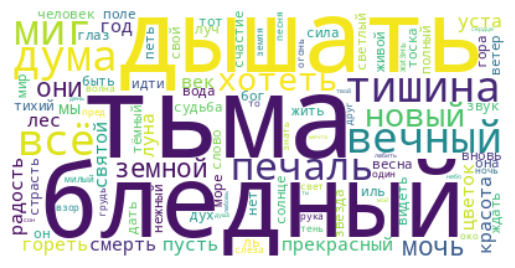

In [50]:
### WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud = WordCloud(background_color='white').generate(str_words_LDA)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [51]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-30:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['милый', 'око', 'пред', 'слеза', 'волна', 'грудь', 'ночь', 'свет', 'песня', 'друг', 'то', 'рука', 'огонь', 'тень', 'земля', 'знать', 'один', 'взор', 'жизнь', 'любить', 'мечта', 'сон', 'небо', 'твой', 'любовь', 'день', 'ты', 'душа', 'сердце', 'мой']


THE TOP 15 WORDS FOR TOPIC #1
['хотеть', 'слава', 'знать', 'хор', 'дать', 'жена', 'они', 'видеть', 'князь', 'сказать', 'меч', 'ребёнок', 'сердце', 'мы', 'враг', 'смерть', 'кровь', 'земля', 'быть', 'нет', 'отец', 'иль', 'рука', 'он', 'сын', 'мой', 'твой', 'бог', 'ты', 'царь']


THE TOP 15 WORDS FOR TOPIC #2
['сквозь', 'смотреть', 'дорога', 'стоить', 'глядеть', 'стать', 'город', 'снег', 'тот', 'день', 'мы', 'дом', 'солнце', 'белый', 'нога', 'вода', 'поле', 'гора', 'лес', 'море', 'земля', 'небо', 'конь', 'ветер', 'чёрный', 'глаз', 'красный', 'рука', 'то', 'идти']


THE TOP 15 WORDS FOR TOPIC #3
['такой', 'любить', 'пойти', 'идти', 'рука', 'они', 'стать', 'человек', 'да', 'какой', 'так', 'друг', 'дать', 'один', '

In [52]:
print(w2v_model)

Word2Vec<vocab=19855, vector_size=3000, alpha=0.03>


In [53]:
model.save("word2vec.model") #сохранить модель

In [54]:
model = Word2Vec.load("word2vec.model") #загрузить модель